In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
%%time
df = pd.read_csv('data/df_cleaned_2.csv', index_col=0, parse_dates=['created_at', 'launched_at', 'deadline', 'state_changed_at'])

Wall time: 2.31 s


In [3]:
df.columns

Index(['backers_count', 'blurb', 'country', 'country_displayable_name',
       'created_at', 'currency', 'currency_symbol', 'deadline',
       'disable_communication', 'goal', 'id', 'is_starrable', 'launched_at',
       'name', 'pledged', 'spotlight', 'staff_pick', 'state',
       'state_changed_at', 'static_usd_rate', 'usd_pledged', 'main_cat',
       'sub_cat', 'loc_name', 'loc_state', 'creator_id', 'creator_name',
       'duration', 'usd_goal', 'fund_rate', 'pledge_perc', 'year', 'month'],
      dtype='object')

In [5]:
df_num = df.loc[:,['backers_count', 'usd_goal', 'usd_pledged', 'duration', 'fund_rate', 'pledge_perc']]

# Question 1: Is there strong correlation between numeric columns of each projects?

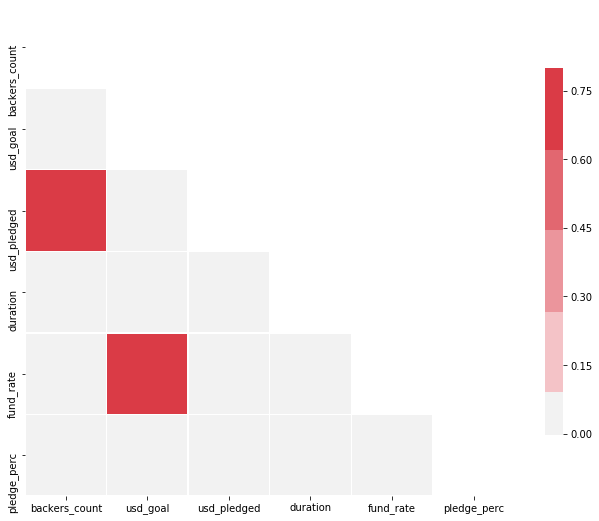

In [6]:
corr = df_num.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(240, 10, n=9)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=0.8, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .75})
plt.show()

Figure 1. Correlation coefficient heat map for numeric columns

From the correlation coefficient heat map, we can see most numeric columns doesn't show strong correlation except total US dollar pledged with number of backers, and US dollor goal with fund rate, which is how much money need to be pledged per day to reach the goal. From our previous EDA session, we know the variation of duration is relative small, so the higher goal was setted, the higher the required fund rate will be, so this is easy to understand. 

However, we are interested in analysize if higher backers count really means higher amount of money will be pledged, which we will use bootstrap statistic method to test in the next session.

# Question 2: Does higher backer count lead to higher usd_pledged? 

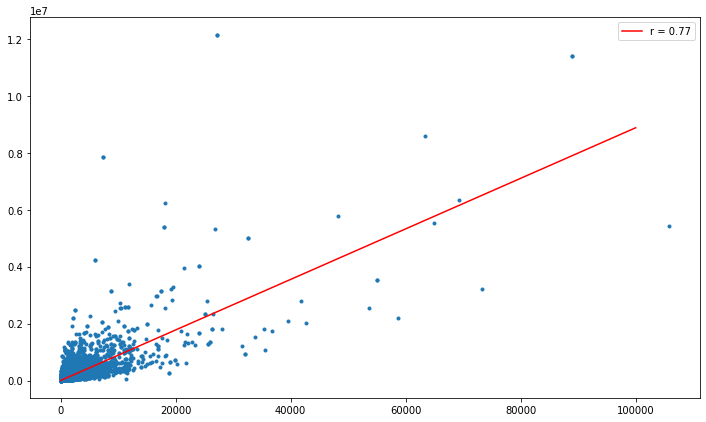

In [7]:
fig, ax = plt.subplots(figsize=(12,7))
backer =  df_num.backers_count
pledged = df_num.usd_pledged
ax.scatter(backer, pledged, marker='.')

a, b = np.polyfit(backer, pledged, 1)

x = np.arange(0, 100000)
ax.plot(x, a*x + b, color='r', label='r = %.2f'%np.corrcoef(backer, pledged)[0,1])
ax.legend()

Use bootstrap to test the confidance interval of r

In [8]:
def pearson_r(x, y):
    return np.corrcoef(x, y)[0,1]

def linear_reg(x,y):
    return np.polyfit(x, y, 1)

Define function draw_bs_pair_choice to draw bootstrap replicates samples by conducting random choice with replacement on indexes, then calculate bootstrap replicates with func which calls two lists.

In [9]:
def draw_bs_pair_choice(x, y, func, size=1000):
    bs_rep = []
    idx = np.arange(0, len(x))
    for i in range(size):
        idx_bs = np.random.choice(idx, size=len(idx))
        bs_rep.append(func(x[idx_bs], y[idx_bs]))
    return np.array(bs_rep)

In [10]:
%%time
bs_rep_r = draw_bs_pair_choice(backer, pledged, pearson_r)

Wall time: 32.9 s


In [11]:
def hist_mean_ci(df, ax, bins=30):
    mean = df.mean()
    ci = np.percentile(df, [2.5, 97.5])
    ax.hist(df, bins=bins)
    ax.vlines(mean, ymin=0, ymax=100, color='red')
    ax.vlines(ci, ymin=0, ymax=100, color='green')

In [12]:
%%time
bs_rep_slope = draw_bs_pair_choice(backer, pledged, linear_reg)

Wall time: 46.3 s


In [13]:
bs_rep_slope1 = bs_rep_slope[:,0]
bs_rep_intcpt = bs_rep_slope[:,1]

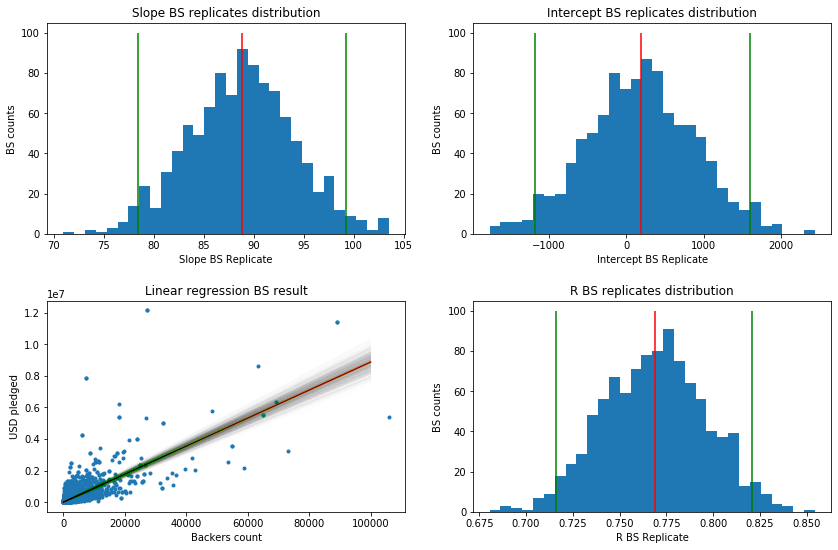

In [14]:
fig, ax = plt.subplots(2,2, figsize=(12,8))
hist_mean_ci(bs_rep_slope1, ax[0,0])
ax[0,0].set_xlabel('Slope BS Replicate')
ax[0,0].set_ylabel('BS counts')
ax[0,0].set_title('Slope BS replicates distribution')
hist_mean_ci(bs_rep_intcpt, ax[0,1])
ax[0,1].set_xlabel('Intercept BS Replicate')
ax[0,1].set_ylabel('BS counts')
ax[0,1].set_title('Intercept BS replicates distribution')
hist_mean_ci(bs_rep_r, ax[1,1])
ax[1,1].set_xlabel('R BS Replicate')
ax[1,1].set_ylabel('BS counts')
ax[1,1].set_title('R BS replicates distribution')
x = np.arange(0, 10000)
ax[1,0].scatter(backer, pledged, marker='.')
a, b = np.polyfit(backer, pledged, 1)
x = np.arange(0, 100000)
ax[1,0].plot(x, a*x + b, color='r')
ax[1,0].set_xlabel('Backers count')
ax[1,0].set_ylabel('USD pledged')
ax[1,0].set_title('Linear regression BS result')
for i in range(len(bs_rep_slope[:, 1])):
    a = bs_rep_slope[i, 0]
    b = bs_rep_slope[i, 1]
    ax[1,0].plot(x, a*x + b, color='g', alpha=0.005)
fig.tight_layout(pad=2)

Figure 2. Bootstrap analysis of backers count and USD pledged linear regression and pearson coefficient

From the result we can see there's a clear linear relation between backers count and usd pledged amount. 95% confidance interval of pearson coefficient is around 0.71 to 0.82. 

## Null hypothesis to prove there's a correlation between backers count number and usd pledged amount 

Null hypothesis: There's no correlation between backers count and usd pledged.\
Alternative hypothesis: There's a correlation between backers count and usd pledged


We assume there's no correlation between backers and usd pledged, so if take bootstrap replicates samples by permutate one set of data and calculate pearson coefficient as bootstrap replicate. Then we calculate corresponding p-value which indicate the possibility of bootstrap replicates reach the test result if null hypothesis is true.

In [15]:
# Define function draw_bs_pairs_permutation for null hypothesis test for r values by permutate one sample, 
# and calculate bootstrap replicates by conducting func which calls two lists.

def draw_bs_pairs_permutation(x, y, func, size=1000):
    bs_rep = np.empty(size)
    for i in range(size):
        x1=np.random.permutation(x)
        bs_rep[i] = func(x1, y)
    return bs_rep   

In [16]:
bs_rep_permute_r = draw_bs_pairs_permutation(backer, pledged, pearson_r)

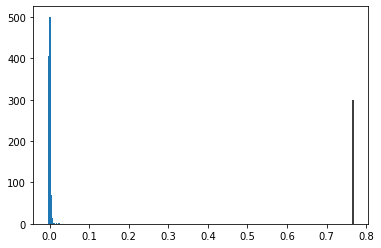

In [17]:
plt.hist(bs_rep_permute_r, bins=10)
plt.vlines(pearson_r(backer, pledged), 0, 300)

In [18]:
p = np.sum(bs_rep_permute_r >= pearson_r(backer, pledged)) / len(bs_rep_permute_r)
p

0.0

From the result we can see p is smaller than 1/1000, which indicate the null hypothesis is most likely not true, which indicate there's a correlation between backers count and usd pledged.

# Question 3: Use Bayersian statistic to study time series 

In [19]:
df.columns

Index(['backers_count', 'blurb', 'country', 'country_displayable_name',
       'created_at', 'currency', 'currency_symbol', 'deadline',
       'disable_communication', 'goal', 'id', 'is_starrable', 'launched_at',
       'name', 'pledged', 'spotlight', 'staff_pick', 'state',
       'state_changed_at', 'static_usd_rate', 'usd_pledged', 'main_cat',
       'sub_cat', 'loc_name', 'loc_state', 'creator_id', 'creator_name',
       'duration', 'usd_goal', 'fund_rate', 'pledge_perc', 'year', 'month'],
      dtype='object')

In [20]:
df_month = df[np.logical_or(df.state == 'successful', df.state == 'failed')].groupby([df.launched_at.dt.strftime('%Y-%m'), 'state']).name.count()
df_month.head()

launched_at  state     
2009-04      failed        1
             successful    4
2009-05      failed        3
             successful    9
2009-06      successful    5
Name: name, dtype: int64

In [21]:
df_by_month = df_month.unstack(fill_value=0)
df_by_month['total'] = df_by_month.failed + df_by_month.successful
df_by_month['pledged'] = df[df.state == 'successful'].groupby(df.launched_at.dt.strftime('%Y-%m')).usd_pledged.sum()

In [22]:
df_by_month=df_by_month[:-2]

In [23]:
total = df_by_month.total
total = total.reset_index().total

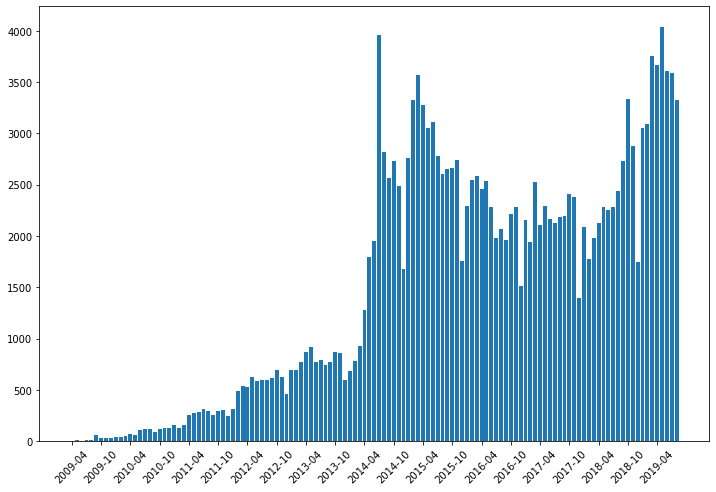

In [24]:
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(1,1,1)
ax.bar(x=df_by_month.index, height=total)
ax.set_xticks(df_by_month.index[::6])
for tick in ax.get_xticklabels():
    tick.set_rotation(45)

Question: Is there a turning point at which project number per month significantly increased?
Module: Use poisson distribution to module project number per month, assume there's a change of parameter, lamda, which use exponential distributed, which call parameter alpha = 1/total.mean()

In [25]:
import pymc3 as pm

In [26]:
with pm.Model() as model:
    alpha = 1/total.mean()
    lamda1 = pm.Exponential('lamda1', alpha)
    lamda2 = pm.Exponential('lamda2', alpha)
    tau = pm.DiscreteUniform('tau', 0, len(total))
    
    idx = total.index
    lamda = pm.math.switch(tau > idx, lamda1, lamda2)
    
    observation = pm.Poisson('obv', lamda, observed = total)

In [27]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(tune=1000)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [lamda2, lamda1]
>Metropolis: [tau]
Sampling 4 chains: 100%|███████████████████████████████████████████████████████| 6000/6000 [00:06<00:00, 867.27draws/s]


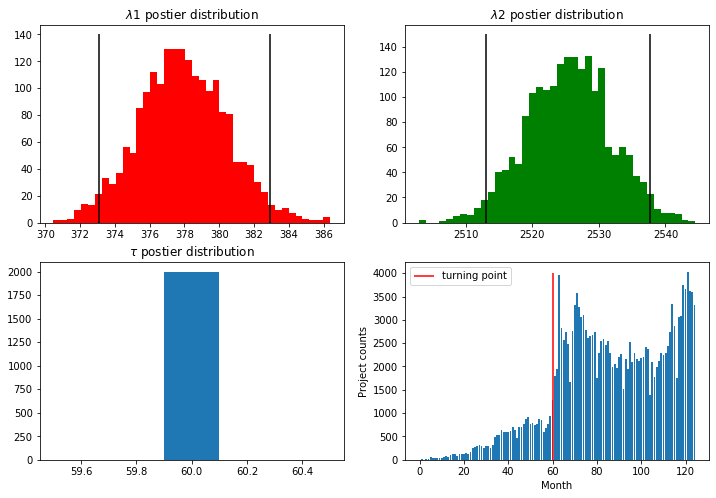

In [28]:
fig, axs = plt.subplots(2,2,figsize=(12,8))
axs[0,0].hist(trace['lamda1'], bins=40, color='red')
axs[0,0].set_title(r'$\lambda$1 postier distribution')
axs[0,0].vlines(np.percentile(trace['lamda1'], [2.5, 97.5]), ymin=0, ymax=140, color='black')
axs[0,1].hist(trace['lamda2'], bins=40, color='green')
axs[0,1].set_title(r'$\lambda$2 postier distribution')
axs[0,1].vlines(np.percentile(trace['lamda2'], [2.5, 97.5]), ymin=0, ymax=150, color='black')
axs[1,0].hist(trace['tau'], bins=5)
axs[1,0].set_title(r'$\tau$ postier distribution')
axs[1,1].bar(x=total.index, height=total)
axs[1,1].vlines(trace['tau'].mean(),0, 4000, color='r', label='turning point')
axs[1,1].set_xlabel('Month')
axs[1,1].set_ylabel('Project counts')
axs[1,1].legend()

Figure 3. Bayersian analysis for project counts over month pattern

From this result, we can clearly see there's a change in project numbers, and it happened on month 60, which is 2014 April. Bayersian trace of tau give one value, which indicate the pattern is very clear that the change happened on this day. Before the change the monthly average is around 372 to 283 projects, and after the change, is from 2512 to 2538, which is a very large increase of traffic.

In [29]:
tp = int(trace['tau'].mean())
t_month = df_by_month.index[tp]
t_month

'2014-04'

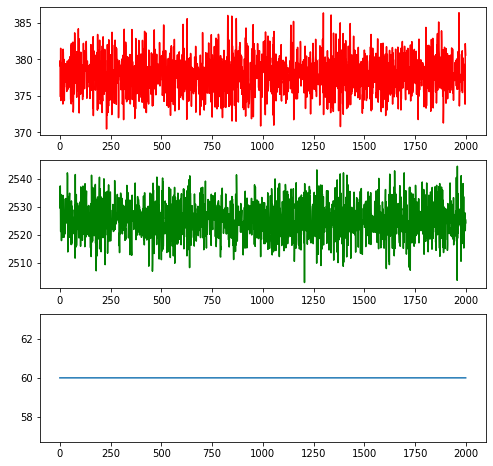

In [30]:
fig, axs = plt.subplots(3, figsize=(8,8))
axs[0].plot(trace['lamda1'], color='red')
axs[1].plot(trace['lamda2'], color='green')
axs[2].plot(trace['tau'])